<a href="https://colab.research.google.com/github/petitmi/Deep_learning-Sequential_data/blob/main/GRU_LSTM_sentiment_analysis_latest_torchtext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep Learning On Sequential Data

I will use custom CSV text dataset for training a simple RNN for sentiment classification (here: a binary classification problem with two labels, positive and negative) using LSTM (Long Short Term Memory) cells and GRU Cells.

In [80]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/586'
# !ls 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/586


In [82]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install torch --upgrade
!pip install torchtext --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [83]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
# from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split


The following cells will download the IMDB movie review dataset (http://ai.stanford.edu/~amaas/data/sentiment/) for positive-negative sentiment classification in as CSV-formatted file:

In [84]:
# !gunzip -f movie_data.csv.gz 
base_csv = 'data/movie_data.csv'
df = pd.read_csv(base_csv)
df.head()

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


### Splitting to train and test data

I will split data to train and test initially.

In [85]:
RANDOM_SEED = 123

import random
raw_data=df[['sentiment','review']].values.tolist()
train_data, valid_data, test_data = random_split(raw_data, [0.75,0.05,0.2], generator=torch.Generator().manual_seed(RANDOM_SEED))
print(f'Num Train: {len(train_data)}')
print(f'Num Valid: {len(valid_data)}')
print(f'Num Test: {len(test_data)}')


Num Train: 37500
Num Valid: 2500
Num Test: 10000


### Analysing sentiment

### Tockenization

**<font color='red'>Note</font>**: I will use the latest version(i.e. `0.15.0`) of `torchtext` instead of the example(i.e. `0.9.0`). 
- Use `data.utils.get_tokenizer` instead of `data.Field`
- `vocab` is also different
- Padding process are differene


In [86]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('basic_english')

In [87]:
from collections import Counter
from torchtext.vocab import vocab
counter = Counter()
for line in df['review']:
    counter.update(tokenizer(line))
vocab = vocab(counter, min_freq=1, specials=('<unk>', '<BOS>', '<EOS>', '<PAD>'))

In [88]:
print("The length of the new vocab is", len(vocab))
new_stoi = vocab.get_stoi()
print("The index of '<BOS>' is", new_stoi['<BOS>'])
new_itos = vocab.get_itos()
print("The token at index 2 is", new_itos[2])

The length of the new vocab is 147160
The index of '<BOS>' is 1
The token at index 2 is <EOS>


In [89]:
text_transform = lambda x: [vocab['<BOS>']] + [vocab[token] for token in tokenizer(x)] + [vocab['<EOS>']]
label_transform = lambda x: float(1) if x == 1 else 0

print("input to the text_transform:", 'this is me')
print("output of the text_transform:", text_transform( 'this is me'))

input to the text_transform: this is me
output of the text_transform: [1, 181, 49, 272, 2]


In [90]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 147160



### Padding, batching and loading as tensor

In [91]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# VOCABULARY_SIZE = 20000
LEARNING_RATE = 1e-4
BATCH_SIZE = 128
NUM_EPOCHS = 15

INPUT_DIM = len(vocab)
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 1
NUM_LAYERS = 1

- Using `DataLoader` to load the data
- Using `collate_fn` function when loading to implement padding

In [92]:

from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

def custom_collate(data): #(2)
    inputs = [torch.tensor(text_transform(d[1])) for d in data] #(3)
    labels = torch.tensor([label_transform(d[0]) for d in data])
    inputs_lens = torch.tensor([len(x) for x in inputs])
    inputs = pad_sequence(inputs, batch_first=True) #(4)
    # inputs = [(d) for d in inputs]

    return labels.to(DEVICE),inputs.to(DEVICE),inputs_lens.to(DEVICE)


Look at the outcome of this function.

In [93]:
custom_collate(list(train_data)[:3])

(tensor([1., 1., 0.], device='cuda:0'),
 tensor([[    1, 71932,    49,  ...,  3856,    24,     2],
         [    1,  2382, 39360,  ...,     0,     0,     0],
         [    1, 43646,  1841,  ...,     0,     0,     0]], device='cuda:0'),
 tensor([528,  54,  59], device='cuda:0'))

In [94]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE,collate_fn=custom_collate)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE,collate_fn=custom_collate)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE,collate_fn=custom_collate)

Have a look at the data, get one:

In [95]:
next(iter(train_loader))

(tensor([0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1.,
         1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
         1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
         1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1.,
         0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
         1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
         0., 1.], device='cuda:0'),
 tensor([[    1,   181,   106,  ...,     0,     0,     0],
         [    1,   457,   153,  ...,     0,     0,     0],
         [    1,   181,   637,  ...,     0,     0,     0],
         ...,
         [    1,   258,  4717,  ...,     0,     0,     0],
         [    1,    50,   371,  ...,     0,     0,     0],
         [    1,  1055, 10006,  ...,     0,     0,     0]], device='cuda:0'),
 tensor([ 

### Model

Put a parameter to control the model, user can set `model = LSTM` or `GRU`.

In [96]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, num_layers,model='LSTM'):
        
        super().__init__()
        #Here is a preliminary model using LSTM cell
        #The primary goal of this lab is to vary the dimensions of the embeddings and see the results
        #The second task is to use a another RNN cell such as GRU and perform parameter tuning and report the results.
        self.model = model
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        if self.model =='LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        elif self.model == 'GRU':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        elif self.model =='Explored-LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim,num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_length):
        embedded = self.embedding(text)
        packed = pack_padded_sequence(embedded, text_length.to('cpu'),batch_first=True,enforce_sorted=False) # Related to the previous pad_sequence
        if self.model =='LSTM' or self.model =='Explored-LSTM':
            packed_output, (hidden, cell)  = self.rnn(packed)
        elif self.model == 'GRU':
            packed_output, hidden = self.rnn(packed)

        return self.fc(hidden[-1].squeeze(0)).view(-1) # Use the last layer's hidden state
        
        # print(packed_output, (hidden, cell))
         

#### LSTM

In [97]:
model_LSTM = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,NUM_LAYERS,'LSTM')
model_LSTM = model_LSTM.to(DEVICE)
optimizer_LSTM = torch.optim.Adam(model_LSTM.parameters(), lr=LEARNING_RATE)

#### GRU

In [98]:
model_GRU = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,NUM_LAYERS,'GRU')
model_GRU = model_GRU.to(DEVICE)
optimizer_GRU = torch.optim.Adam(model_GRU.parameters(), lr=LEARNING_RATE)

#### Explored LSTM
Changed num_layers to 2

In [99]:

# LEARNING_RATE = 1e-4
# BATCH_SIZE = 128
# NUM_EPOCHS = 15

# INPUT_DIM = len(vocab)
# EMBEDDING_DIM = 128
# HIDDEN_DIM = 256
# OUTPUT_DIM = 1
# NUM_LAYERS = 1
model_LSTM_E = RNN(input_dim=len(vocab), embedding_dim=128, hidden_dim = 256, output_dim = 1,num_layers=2,model='Explored-LSTM')
model_LSTM_E = model_LSTM_E.to(DEVICE)
optimizer_LSTM_E = torch.optim.Adam(model_LSTM_E.parameters(), lr=LEARNING_RATE)

### Training

In [100]:
def compute_binary_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for idx, (label, text, text_length) in enumerate(data_loader):
            logits = model(text,text_length)
            predicted_labels = (torch.sigmoid(logits) > 0.5).long()
            num_examples += label.size(0)#change
            correct_pred += (predicted_labels.long() == label.long()).sum()#change
        return correct_pred.float()/num_examples * 100

In [101]:
import time
def model_train(model,optimizer,num_epochs):
    start_time = time.time()
    costs=[]
    train_accs=[]
    valid_accs=[]
    for epoch in range(num_epochs):
        model.train()
        for idx, (label, text,text_length) in enumerate(train_loader):
            
            ### FORWARD AND BACK PROP
            logits = model(text, text_length)
            cost = F.binary_cross_entropy_with_logits(logits, label)
            optimizer.zero_grad()
            cost.backward()
            
            ### UPDATE MODEL PARAMETERS
            optimizer.step()
            
            ### LOGGING
            if not idx % 50:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} | '
                    f'Batch {idx:03d}/{len(train_loader):03d} | '
                    f'Cost: {cost:.4f}')

        with torch.set_grad_enabled(False):
            costs.append(cost)
            training_acc = compute_binary_accuracy(model, train_loader, DEVICE)
            valid_acc = compute_binary_accuracy(model, valid_loader, DEVICE)
            train_accs.append(training_acc)
            valid_accs.append(valid_acc)

            print(f'training accuracy: '
                f'{training_acc:.2f}%'
                f'\nvalid accuracy: '
                f'{valid_acc:.2f}%')
            
        print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
        
    print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
    print(f'Test accuracy: {compute_binary_accuracy(model, test_loader, DEVICE):.2f}%')
    return costs,train_accs,valid_accs

In [102]:
#LSTM
costs_LSTM,train_accs_LSTM,valid_accs_LSTM = model_train(model_LSTM, optimizer_LSTM, NUM_EPOCHS)

Epoch: 001/015 | Batch 000/293 | Cost: 0.6924
Epoch: 001/015 | Batch 050/293 | Cost: 0.6812
Epoch: 001/015 | Batch 100/293 | Cost: 0.6919
Epoch: 001/015 | Batch 150/293 | Cost: 0.6876
Epoch: 001/015 | Batch 200/293 | Cost: 0.6663
Epoch: 001/015 | Batch 250/293 | Cost: 0.5996
training accuracy: 71.97%
valid accuracy: 70.76%
Time elapsed: 0.83 min
Epoch: 002/015 | Batch 000/293 | Cost: 0.5501
Epoch: 002/015 | Batch 050/293 | Cost: 0.5554
Epoch: 002/015 | Batch 100/293 | Cost: 0.5326
Epoch: 002/015 | Batch 150/293 | Cost: 0.5316
Epoch: 002/015 | Batch 200/293 | Cost: 0.4948
Epoch: 002/015 | Batch 250/293 | Cost: 0.4329
training accuracy: 79.45%
valid accuracy: 76.40%
Time elapsed: 1.63 min
Epoch: 003/015 | Batch 000/293 | Cost: 0.4088
Epoch: 003/015 | Batch 050/293 | Cost: 0.5005
Epoch: 003/015 | Batch 100/293 | Cost: 0.4597
Epoch: 003/015 | Batch 150/293 | Cost: 0.4176
Epoch: 003/015 | Batch 200/293 | Cost: 0.4086
Epoch: 003/015 | Batch 250/293 | Cost: 0.3616
training accuracy: 83.31%
va

In [104]:
#GRU
costs_GRU, train_accs_GRU, valid_accs_GRU = model_train(model_GRU, optimizer_GRU,NUM_EPOCHS)

Epoch: 001/015 | Batch 000/293 | Cost: 0.6966
Epoch: 001/015 | Batch 050/293 | Cost: 0.6922
Epoch: 001/015 | Batch 100/293 | Cost: 0.6829
Epoch: 001/015 | Batch 150/293 | Cost: 0.6796
Epoch: 001/015 | Batch 200/293 | Cost: 0.6615
Epoch: 001/015 | Batch 250/293 | Cost: 0.5738
training accuracy: 72.21%
valid accuracy: 72.00%
Time elapsed: 0.84 min
Epoch: 002/015 | Batch 000/293 | Cost: 0.5970
Epoch: 002/015 | Batch 050/293 | Cost: 0.4564
Epoch: 002/015 | Batch 100/293 | Cost: 0.4834
Epoch: 002/015 | Batch 150/293 | Cost: 0.5470
Epoch: 002/015 | Batch 200/293 | Cost: 0.5043
Epoch: 002/015 | Batch 250/293 | Cost: 0.4917
training accuracy: 79.85%
valid accuracy: 78.32%
Time elapsed: 1.66 min
Epoch: 003/015 | Batch 000/293 | Cost: 0.5123
Epoch: 003/015 | Batch 050/293 | Cost: 0.4154
Epoch: 003/015 | Batch 100/293 | Cost: 0.4145
Epoch: 003/015 | Batch 150/293 | Cost: 0.3582
Epoch: 003/015 | Batch 200/293 | Cost: 0.3651
Epoch: 003/015 | Batch 250/293 | Cost: 0.3359
training accuracy: 83.85%
va

In [103]:
#LSTM-E
costs_LSTM_E, train_accs_LSTM_E, valid_accs_LSTM_E = model_train(model_LSTM_E, optimizer_LSTM_E, 18)

Epoch: 001/015 | Batch 000/293 | Cost: 0.6966
Epoch: 001/015 | Batch 050/293 | Cost: 0.6909
Epoch: 001/015 | Batch 100/293 | Cost: 0.6886
Epoch: 001/015 | Batch 150/293 | Cost: 0.6173
Epoch: 001/015 | Batch 200/293 | Cost: 0.6011
Epoch: 001/015 | Batch 250/293 | Cost: 0.5841
training accuracy: 72.23%
valid accuracy: 71.36%
Time elapsed: 1.05 min
Epoch: 002/015 | Batch 000/293 | Cost: 0.5589
Epoch: 002/015 | Batch 050/293 | Cost: 0.6389
Epoch: 002/015 | Batch 100/293 | Cost: 0.6320
Epoch: 002/015 | Batch 150/293 | Cost: 0.5292
Epoch: 002/015 | Batch 200/293 | Cost: 0.5545
Epoch: 002/015 | Batch 250/293 | Cost: 0.4905
training accuracy: 75.92%
valid accuracy: 74.12%
Time elapsed: 2.08 min
Epoch: 003/015 | Batch 000/293 | Cost: 0.3985
Epoch: 003/015 | Batch 050/293 | Cost: 0.4712
Epoch: 003/015 | Batch 100/293 | Cost: 0.4484
Epoch: 003/015 | Batch 150/293 | Cost: 0.4140
Epoch: 003/015 | Batch 200/293 | Cost: 0.3685
Epoch: 003/015 | Batch 250/293 | Cost: 0.4145
training accuracy: 82.21%
va

### Inferance

In [141]:
r_LSTM = pd.DataFrame({'costs':[x.detach().cpu().item() for x in costs_LSTM],
                       'train_accs':[x.detach().cpu().item() for x in train_accs_LSTM],
                       'valid_accs':[x.detach().cpu().item() for x in valid_accs_LSTM]})
r_LSTM_E = pd.DataFrame({'costs':[x.detach().cpu().item() for x in costs_LSTM_E],
                       'train_accs':[x.detach().cpu().item() for x in train_accs_LSTM_E],
                       'valid_accs':[x.detach().cpu().item() for x in valid_accs_LSTM_E]})
r_GRU = pd.DataFrame({'costs':[x.detach().cpu().item() for x in costs_GRU],
                       'train_accs':[x.detach().cpu().item() for x in train_accs_GRU],
                       'valid_accs':[x.detach().cpu().item() for x in valid_accs_GRU]})

In [148]:
print('LSTM')
print(r_LSTM.iloc[-1,:])
print('\nExplored LSTM')
print(r_LSTM_E.iloc[-1,:])
print('\nGRU')
print(r_GRU.iloc[-1,:])

LSTM
costs          0.160214
train_accs    95.309334
valid_accs    87.519997
Name: 14, dtype: float64

Explored LSTM
costs          0.148501
train_accs    95.431999
valid_accs    87.959999
Name: 14, dtype: float64

GRU
costs          0.175244
train_accs    94.218666
valid_accs    87.639999
Name: 14, dtype: float64


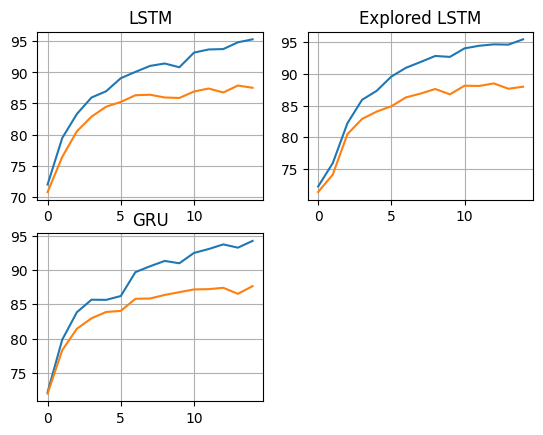

In [143]:
from tables.table import Col
import matplotlib.pyplot as plt
plt.figure(1)
plt.subplot(221)
plt.plot(r_LSTM[['train_accs','valid_accs']])
plt.title('LSTM')
plt.grid(True)


# log
plt.subplot(222)
plt.plot(r_LSTM_E[['train_accs','valid_accs']])
plt.title('Explored LSTM')
plt.grid(True)


# symmetric log
plt.subplot(223)
plt.plot(r_GRU[['train_accs','valid_accs']])
plt.title('GRU')
plt.grid(True)

In [105]:
import spacy
# nlp = spacy.load('en')

def predict_sentiment(model, sentence):
    # based on:
    # https://github.com/bentrevett/pytorch-sentiment-analysis/blob/
    # master/2%20-%20Upgraded%20Sentiment%20Analysis.ipynb
    model.eval()
    # tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    input = torch.tensor(text_transform(sentence)).unsqueeze(dim=1).to(DEVICE)
    length = torch.tensor([len(input)]).to(DEVICE)
    input = pad_sequence(input)
    prediction = torch.sigmoid(model(input, length))
    
    return prediction.item()

In [152]:
s_input = "I love it so much!"
p_LSTM = predict_sentiment(model_LSTM, s_input)
p_LSTM_E = predict_sentiment(model_LSTM_E, s_input)
p_GRU=predict_sentiment(model_GRU, s_input)
print(f"MODEL LSTM: {p_LSTM}")
print(f"MODEL Explored LSTM: {p_LSTM_E}")
print(f"MODEL GRU: {p_GRU}")

MODEL LSTM: 0.8334485292434692
MODEL Explored LSTM: 0.9254704117774963
MODEL GRU: 0.8174559473991394


In [154]:
s_input = "I hate this movie. There are so many bad jokes. And the plots are designed so foolish and sucks!"
p_LSTM = predict_sentiment(model_LSTM, s_input)
p_LSTM_E = predict_sentiment(model_LSTM_E, s_input)
p_GRU=predict_sentiment(model_GRU, s_input)
print(f"MODEL LSTM: {p_LSTM}")
print(f"MODEL Explored LSTM: {p_LSTM_E}")
print(f"MODEL GRU: {p_GRU}")

MODEL LSTM: 0.032665230333805084
MODEL Explored LSTM: 0.026598457247018814
MODEL GRU: 0.10575702041387558


### Conclusion

The LSTM with two hidden layers (i.e. Explored LSTM) is the best model with higher accuracy and lower cost. Additionally, the inference performance is also better than the other.